In [19]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph
from shapely import geometry
import time 
ox.settings.bidirectional_network_types = ["drive"]

''' Определение тегов '''
tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

''' Построение датафрейма нужных фич '''
def func_tags(tags, city):

    try:
        gdf = ox.features_from_place(city, tags).reset_index()
        gdf = gdf[['element_type', 'osmid']]
        gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)

        list_lat_lon = []
        for i in range(gdf.n_osmid.shape[0]):
            try:
                bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
                list_lat_lon.append(bb.iloc[:])
            except ox._errors.InsufficientResponseError:
                list_lat_lon.append(pd.DataFrame({'lat': [None], 'lon': [None]}))
        dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
        gdf = gdf.merge(dfs, on=dfs.index).drop('key_0', axis=1)
        gdf = gdf[['lat', 'lon']]
        gdf['kind_of'] = list(tags.keys())[0]
        gdf = gdf.dropna().reset_index(drop=True)
        return gdf
    except ox._errors.InsufficientResponseError:
        return None

''' Построение графа, получение датафрейма фич и получение датафрейма долгот и широт для дальшейших вычислений '''
def create_graph_city(name_city, my_network_type = None, my_filter = None):
    full_df = pd.concat([func_tags(tags_port, name_city), 
                                    func_tags(tags_aeroway, name_city), 
                                    func_tags(tags_landuse, name_city), 
                                    func_tags(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon

''' Формирование датафрейма фич '''
def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df


''' Создание датафрейма со всеми маршрутами '''
def create_graph_route(input_graph, f_df):
    one_route = []
    for i in range(f_df.shape[0]):
        for j in range(i + 1, f_df.shape[0]):
            try:
                one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))
            except nx.NetworkXNoPath:
                pass
    route_df = pd.DataFrame({'route' : one_route})
    return route_df


''' Создание из нескольких LineString один MultiLineString - нужно для финального графа '''
def create_gdf_graph(nn, ee):
    ii = 0
    list_line = []
    list_multi_line = []
    for i in range(nn.shape[0] - 1):
        idx = nn.iloc[i + 1].new_nodes
        for j in range(ii, ee.index.get_level_values('u').shape[0]):
            if ee.index.get_level_values('u')[j] != idx:
                for k in range(len(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values)):
                    list_line.append(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values[k])
            else : 
                ii = j
        multi_line = geometry.MultiLineString(list_line)
        list_line = []
        list_multi_line.append(multi_line)
    return list_multi_line


''' Построение финального графа путей '''
def create_final_graph(arb_graph, route_df, feature_df):
    list_graphs = []
    for i in range(route_df.route.shape[0]):
        r = route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])

    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(feature_df['new_nodes'].values)
    n = nodes[nodes['new_nodes'].isin(list_nodes)]

    list_multiline = create_gdf_graph(n, edges)
    edge_dict = {'u': n.new_nodes[:-1].values, 'v': n.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])
    edge_gdf['geometry'] = list_multiline
    graph_attrs = {"crs": "WGS84"}
    multi_digraph = ox.graph_from_gdfs(
        n, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph

In [20]:
# 定义 result 函数
def result(name_city):
    start_time = time.time()  # 记录开始时间

    graph_city = create_graph_city(name_city, my_network_type='drive')
    feature_df = create_features_city(*graph_city)
    ox.distance.add_edge_lengths(graph_city[1], edges=None)
    route_df = create_graph_route(graph_city[1], feature_df)
    final_graph_1_drive = create_final_graph(graph_city[1], route_df, feature_df)

    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算总耗时

    print(f"Total execution time: {elapsed_time:.2f} seconds")  # 输出总耗时

    return final_graph_1_drive

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 22646.91 seconds


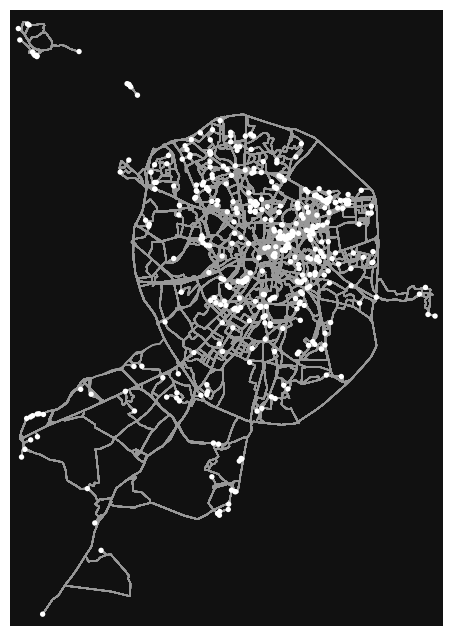

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
name_city = 'Moscow'#Москва
res_6 = result(name_city)
ox.plot_graph(res_6)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

Total execution time: 6300.98 seconds


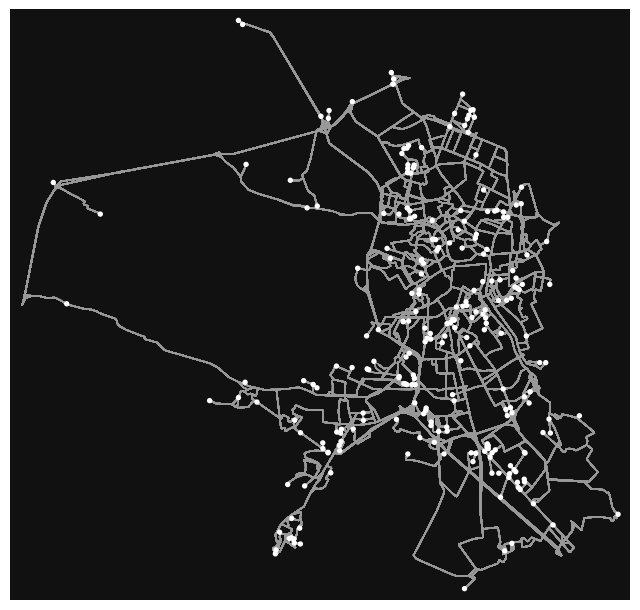

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [18]:
name_city = 'Saint Petersburg'#Санкт-Петербург
res_5 = result(name_city)
ox.plot_graph(res_5)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 246.42 seconds


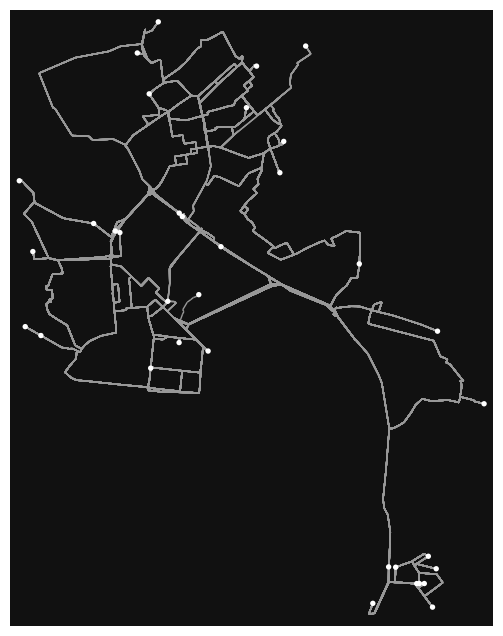

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
name_city = 'Novosibirsk'#Новосибирск
res_7 = result(name_city)
ox.plot_graph(res_7)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 355.33 seconds


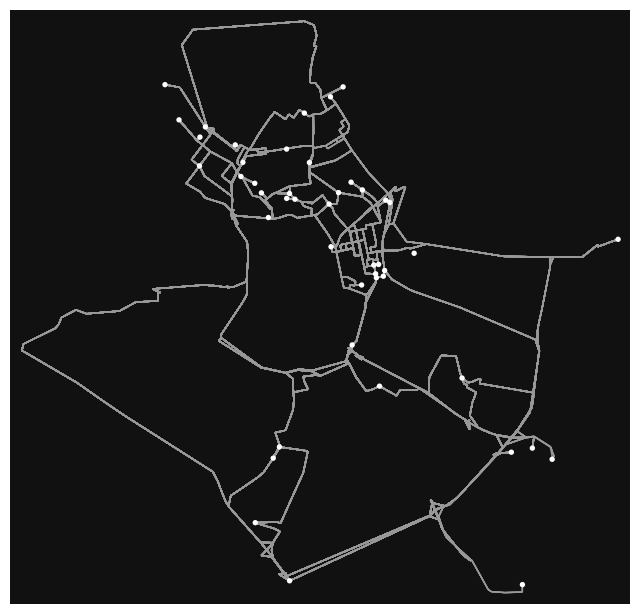

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
name_city = 'Yekaterinburg'#Екатеринбург
res_8 = result(name_city)
ox.plot_graph(res_8)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 45.83 seconds


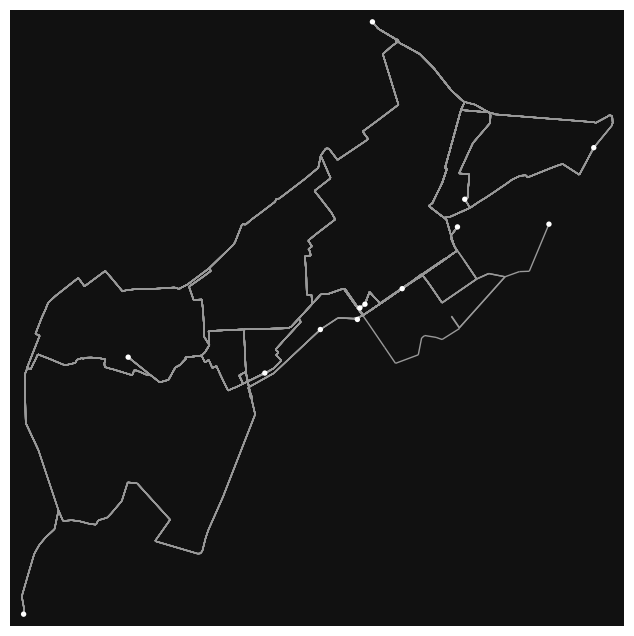

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [22]:
name_city = 'Samara'
res_19 = result(name_city)
ox.plot_graph(res_19)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 62.87 seconds


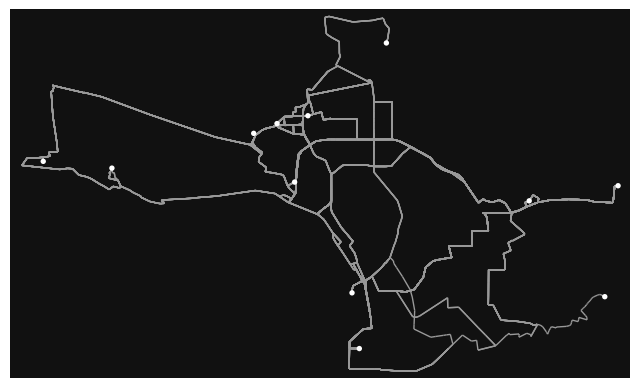

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
name_city = 'Kazan'#Казань
res_9 = result(name_city)
ox.plot_graph(res_9)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


Total execution time: 182.57 seconds


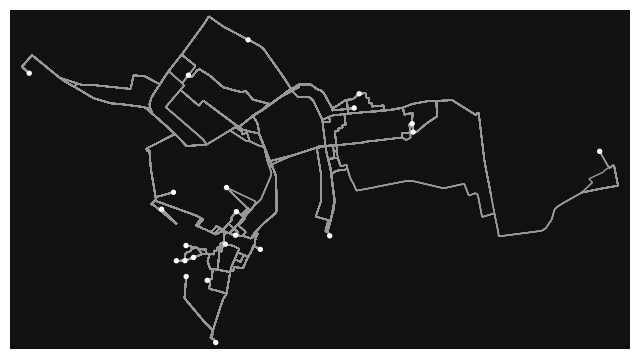

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
name_city = 'Omsk'#Омск
res_10 = result(name_city)
ox.plot_graph(res_10)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 178.92 seconds


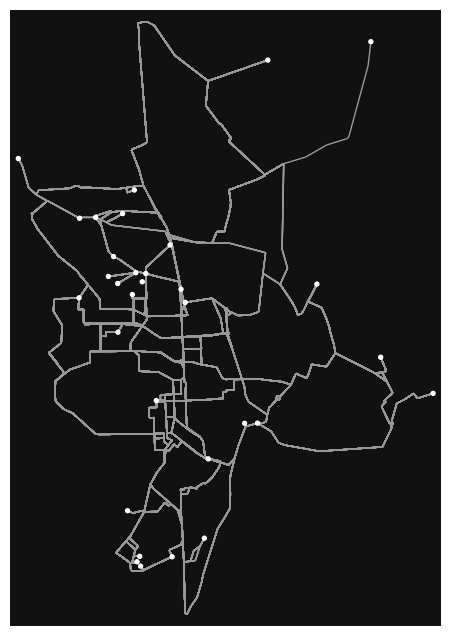

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
name_city = 'Chelyabinsk'
res_21 = result(name_city)
ox.plot_graph(res_21)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 74.39 seconds


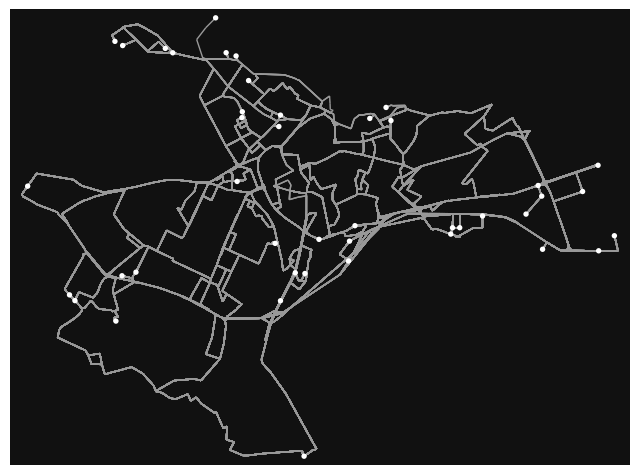

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
name_city = 'Tallin'
res_1 = result(name_city)
ox.plot_graph(res_1)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

Total execution time: 483.64 seconds


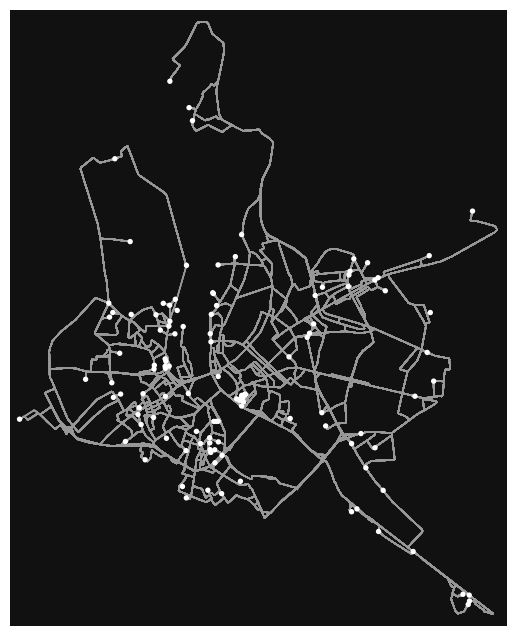

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [15]:
name_city = 'Riga'
res_2 = result(name_city)
ox.plot_graph(res_2)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 19.40 seconds


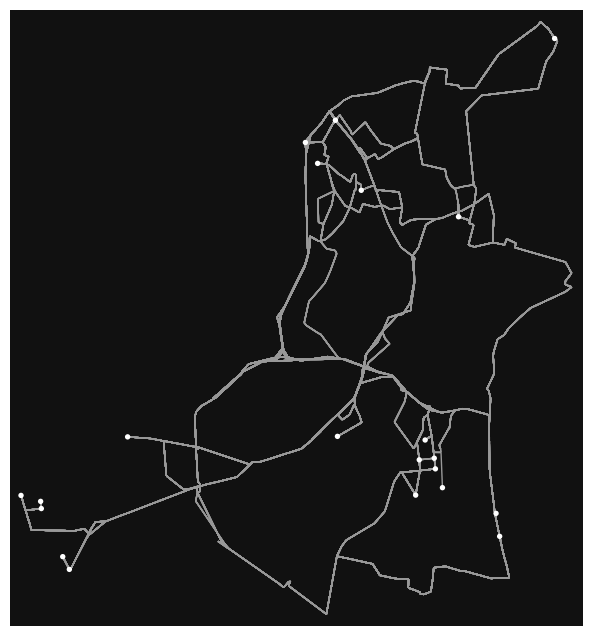

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [16]:
name_city = 'Vilnius'#Вильнюс
res_3 = result(name_city)
ox.plot_graph(res_3)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 0.90 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


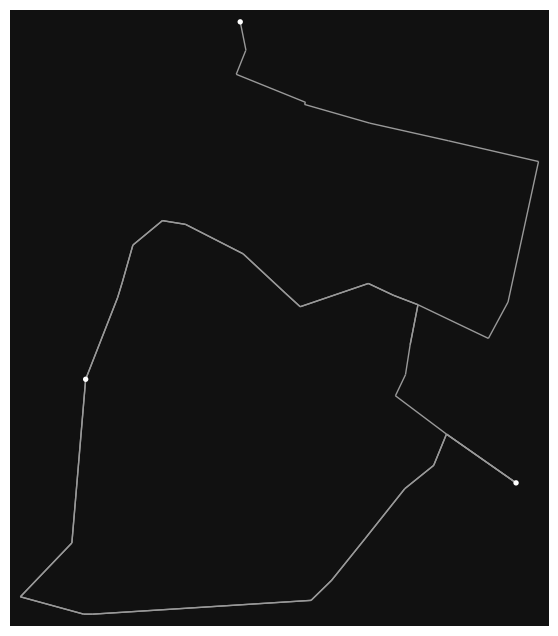

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
name_city = 'Strelna'
res_4 = result(name_city)
ox.plot_graph(res_4)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 78.04 seconds


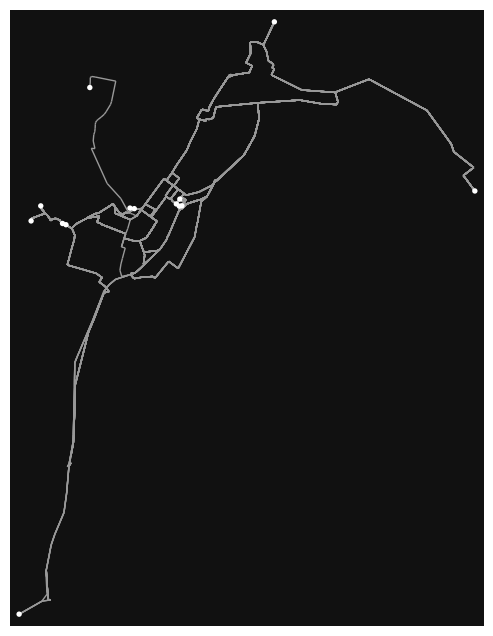

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
name_city = 'Ufa'
res_11 = result(name_city)
ox.plot_graph(res_11)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 330.71 seconds


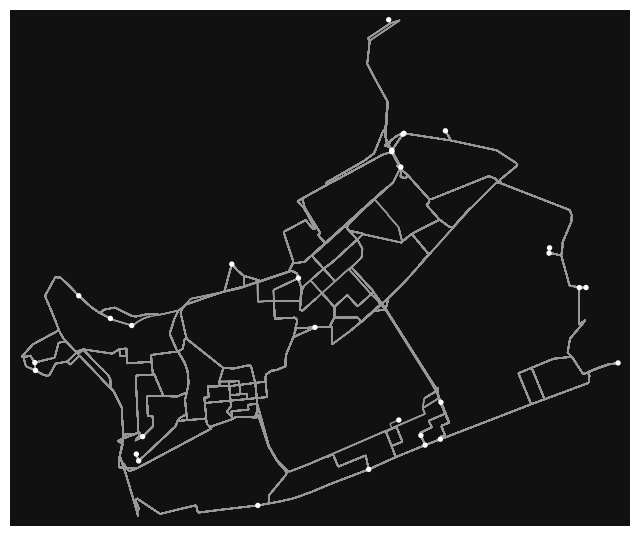

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
name_city = 'Krasnoyarsk'
res_12 = result(name_city)
ox.plot_graph(res_12)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 109.46 seconds


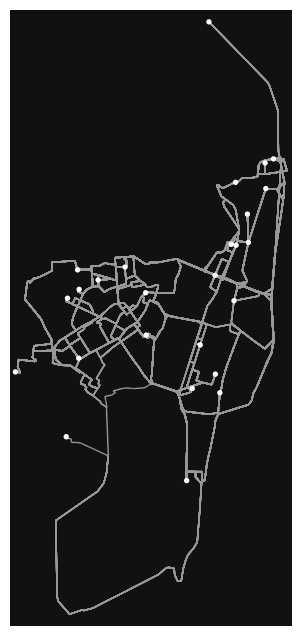

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
name_city = 'Voronezh'
res_13 = result(name_city)
ox.plot_graph(res_13)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 85.22 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


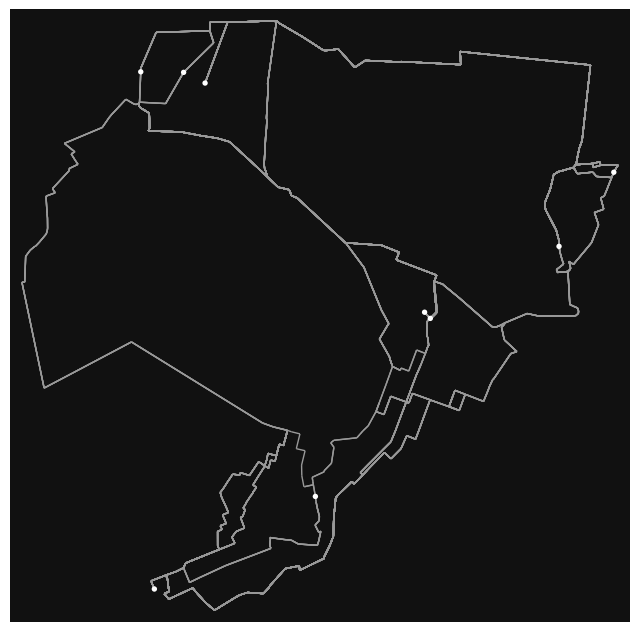

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [13]:
name_city = 'Saratov'
res_14 = result(name_city)
ox.plot_graph(res_14)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 64.65 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


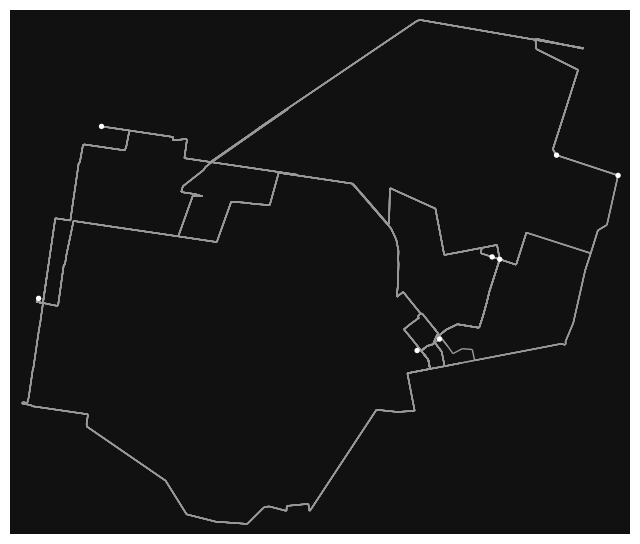

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
name_city = 'Togliatti'
res_15 = result(name_city)
ox.plot_graph(res_15)

D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo

Total execution time: 324.45 seconds


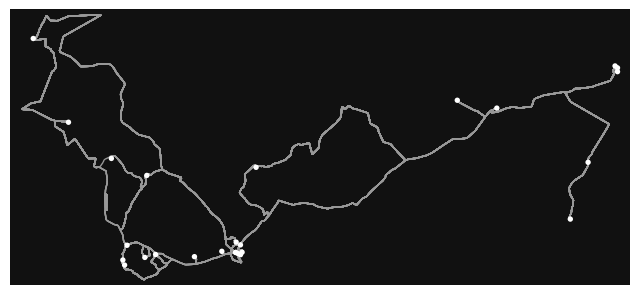

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [26]:
name_city = 'Vologda'
res_16 = result(name_city)
ox.plot_graph(res_16)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


Total execution time: 105.67 seconds


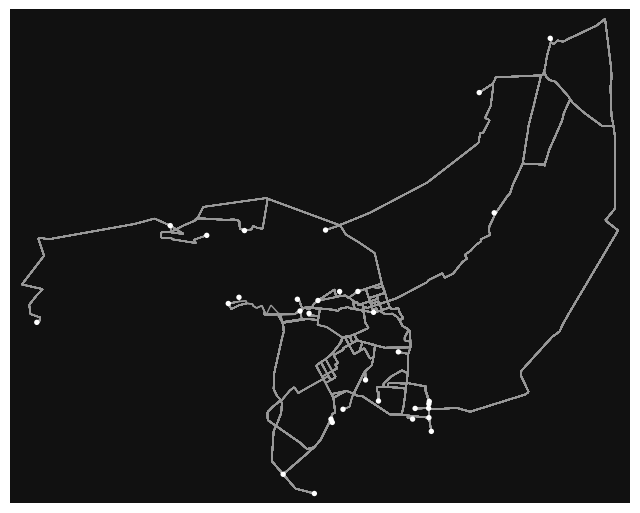

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [25]:
name_city = 'Perm'
res_17 = result(name_city)
ox.plot_graph(res_17)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 112.85 seconds


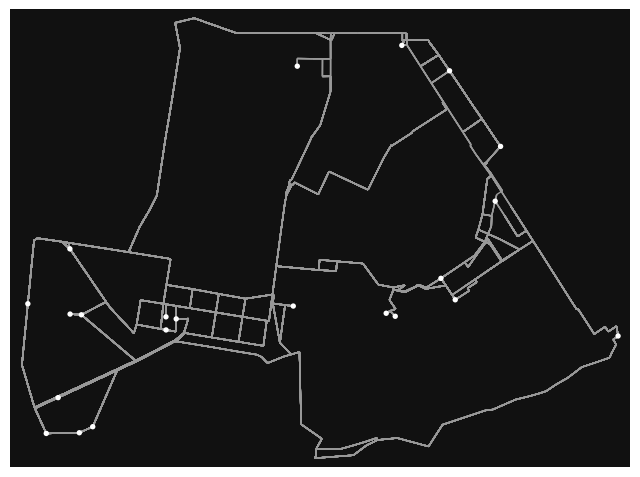

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [24]:
name_city = 'Barnaul'
res_18 = result(name_city)
ox.plot_graph(res_18)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 104.66 seconds


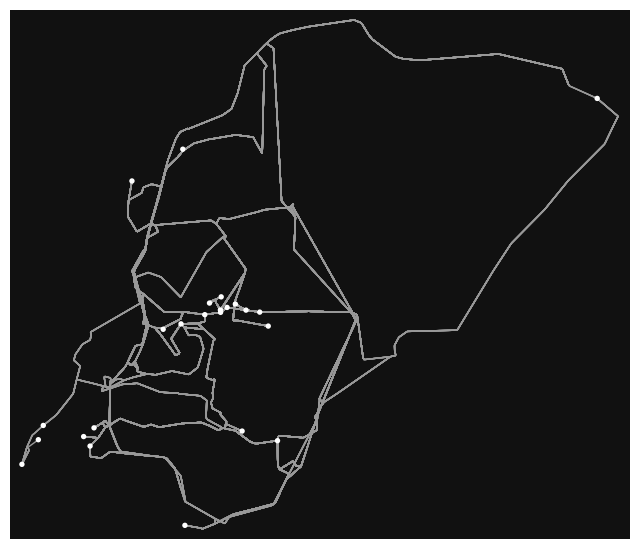

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
name_city = 'Vladivostok '
res_20 = result(name_city)
ox.plot_graph(res_20)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 63.76 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


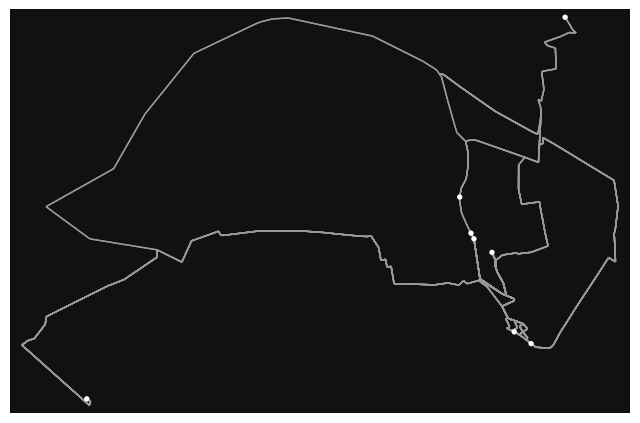

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [28]:
name_city = 'Chita '
res_22 = result(name_city)
ox.plot_graph(res_22)

D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 145 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 145 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 145 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_

Total execution time: 1086.12 seconds


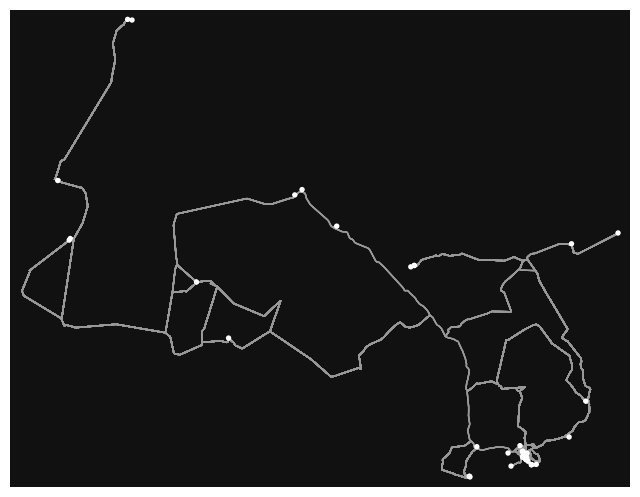

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [32]:
name_city = 'Tomsk '
res_23 = result(name_city)
ox.plot_graph(res_23)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 29.97 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


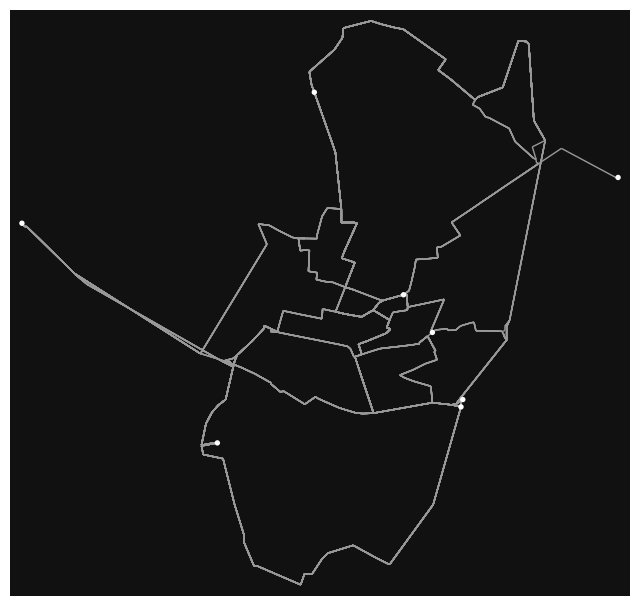

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [33]:
name_city = 'Kaluga'
res_24 = result(name_city)
ox.plot_graph(res_24)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 8.12 seconds


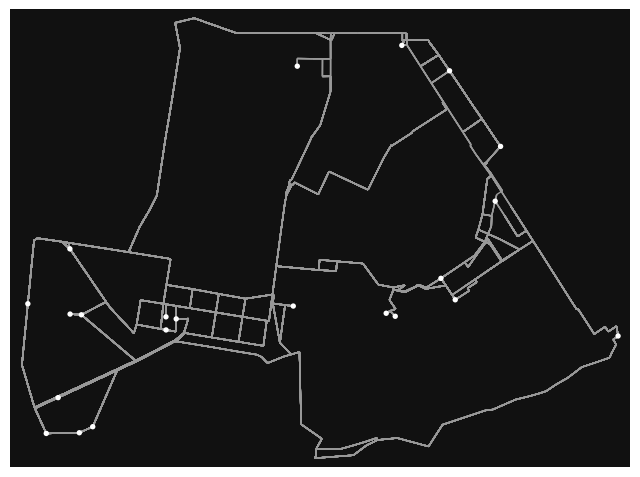

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [34]:
name_city = 'Barnaul'
res_24 = result(name_city)
ox.plot_graph(res_24)

1	Yakutsk	雅库茨克	Якутск	3,083
2	Moscow	莫斯科	Москва	2,511
3	Saint Petersburg	圣彼得堡	Санкт-Петербург	1,439
4	Novosibirsk	新西伯利亚	Новосибирск	505
5	Yekaterinburg	叶卡捷琳堡	Екатеринбург	468
6	Chelyabinsk	奇里雅宾斯克	Челябинск	531
7	Nizhny Novgorod	下诺夫哥罗德	Нижний Новгород	466
8	Kazan	喀山	Казань	425
9	Omsk	鄂木斯克	Омск	577
10	Samara	萨马拉	Самара	540
11	Ufa	乌法	Уфа	707
12	Voronezh	沃罗涅日	Воронеж	400
13	Saratov	萨拉托夫	Саратов	367
14	Tolyatti	托利亚蒂	Тольятти	267
15	Krasnoyarsk	克拉斯诺亚尔斯克	Красноярск	388
16	Volgograd	伏尔加格勒	Волгоград	850
17	Irkutsk	伊尔库茨克	Иркутск	247
18	Khabarovsk	哈巴罗夫斯克	Хабаровск	371
19	Vladivostok	海参崴	Владивосток	600
20	Chita	赤塔	Чита	300
21	Barnaul	巴尔瑙尔	Барнаул	222
22	Penza	彭萨	Пенза	72
23	Naberezhnye Chelny	纳巴捷兹哈切尔尼	Набережные Челны	193
24	Surgut	苏尔古特	Сургут	223
25	Kaluga	卡卢加	Калуга	87
26	Kurgan	库尔干	Курган	77
27	Bryansk	布良斯克	Брянск	150
28	Tomsk	托木斯克	Томск	119
29	Ulan-Ude	乌兰乌德	Улан-Удэ	450
30	Sochi	索契	Сочи	377
31	Arkhangelsk	阿尔汉格尔斯克	Архангельск	47
32	Makhachkala	马哈奇卡拉	Махачкала	50
33	Murmansk	摩尔曼斯克	Мурманск	154
34	Petrozavodsk	彼得罗扎沃茨克	Петрозаводск	92
35	Vologda	沃罗涅什	Вологда	430
36	Kirov	基洛夫	Киров	325
37	Smolensk	斯摩棱斯克	Смоленск	145
38	Rybinsk	瑞宾斯克	Рыбинск	138
39	Cheboksary	切博克萨雷	Чебоксары	221
40	Tver	特维尔	Тверь	22
41	Novokuznetsk	新库兹涅茨克	Новокузнецк	228
42	Veliky Novgorod	大诺夫哥罗德	Великий Новгород	198
43	Toguchin	托古钦	Тогучин	117
44	Nizhnekamsk	下卡姆斯克	Нижнекамск	112
45	Sovetsk	苏维埃斯克	Советск	32
46	Lysva	利斯瓦	Лысьва	56
47	Kamensk-Uralsky	卡门斯克乌拉尔斯基	Каменск-Уральский	125
48	Aznakaevо	阿兹纳凯沃	Азнакаево	26
49	Mytishchi	米季什契	Мытищи	25
50	Zelenograd	泽伦格拉德	Зеленоград	31

In [ ]:
#nodes_1, edges_1 = ox.graph_to_gdfs(res_1)
#nodes_2, edges_2 = ox.graph_to_gdfs(res_2)
#nodes_3, edges_3 = ox.graph_to_gdfs(res_3)
#nodes_4, edges_4 = ox.graph_to_gdfs(res_4)

#nodes_1.to_csv('data/nodes_tallin.csv')
#edges_1.to_csv('data/edges_tallin.csv')
#nodes_2.to_csv('data/nodes_riga.csv')
#edges_2.to_csv('data/edges_riga.csv')
#nodes_3.to_csv('data/nodes_vilnius.csv')
#edges_3.to_csv('data/edges_vilnius.csv')
#nodes_4.to_csv('data/nodes_strelna.csv')
#edges_4.to_csv('data/edges_strelna.csv')